In [1]:
import numpy
import math
from scipy import integrate, linalg
from matplotlib import pyplot
%matplotlib inline

In [2]:
class Panel:
    """Contains information related to one panel."""
    def __init__(self, xa, ya, xb, yb):
        """Creates a panel.
        
        Arguments
        ---------
        xa, ya -- Cartesian coordinates of the first end-point.
        xb, yb -- Cartesian coordinates of the second end-point.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2       # control-point (center-point)
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)     # length of the panel
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.0:
            self.beta = numpy.arccos((yb-ya)/self.length)
        elif xb-xa > 0.0:
            self.beta = math.pi + numpy.arccos(-(yb-ya)/self.length)
        
        # location of the panel
        if self.beta <= math.pi:
            self.loc = 'upper'
        else:
            self.loc = 'lower'
        
        self.sigma = 0.                             # source strength
        self.vt = 0.                                # tangential velocity
        self.cp = 0.                                # pressure coefficient

def define_panels(x, y, N):
    """Discretizes the geometry into panels using input arrays for the ends of the panels.
    
    Arguments
    ---------
    x, y -- Cartesian coordinates of the panel endpoints.
    N - number of panels.
    
    Returns
    -------
    panels -- Numpy array of panels.
    """
    x_ends, y_ends = x, y
    panels = numpy.empty(N, dtype=object)
    
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
    
    return panels

class Freestream:
    """Freestream conditions."""
    def __init__(self, u_inf, alpha):
        """Sets the freestream conditions.
        
        Parameters
        ----------
        u_inf: float
            Freestream speed; default: 1.0.
        alpha: float
            Angle of attack in degrees; default 0.0.
        """
        self.u_inf = u_inf
        self.alpha = alpha*numpy.pi/180.0 # degrees to radians

def integral(x, y, panel, dxdk, dydk):
    """Evaluates the contribution from a panel at a given point.
    
    Parameters
    ----------
    x, y: float
        Coordinates of the point.
    panel: Panel object
        Panel whose contribution is evaluated.
    dxdk: float
        Value of the derivative of x in a certain direction.
    dydk: float
        Value of the derivative of y in a certain direction.
    
    Returns
    -------
    Contribution from panel at point (x, y).
    """
    def func(s):
        return ( ((x - (panel.xa - numpy.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + numpy.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2
                   +(y - (panel.ya + numpy.cos(panel.beta)*s))**2) )
    return integrate.quad(func, 0., panel.length)[0]

def source_contribution_normal(panels):
    """Builds the source contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: Numpy 1d array (Panel object)
        List of panels.
    
    Returns
    -------
    A: Numpy 2d array (float)
        Source contribution matrix.
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    numpy.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                panel_j,
                                                numpy.cos(panel_i.beta),
                                                numpy.sin(panel_i.beta))
    return A

def vortex_contribution_normal(panels):
    """Builds the vortex contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: Numpy 1d array (Panel object)
        List of panels.
    
    Returns
    -------
    A: Numpy 2d array (float)
        Vortex contribution matrix.
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    numpy.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 numpy.sin(panel_i.beta),
                                                 -numpy.cos(panel_i.beta))
    return A

def kutta_condition(A_source, B_vortex):
    """Builds the Kutta condition array.
    
    Parameters
    ----------
    A_source: Numpy 2d array (float)
        Source contribution matrix for the normal velocity.
    B_vortex: Numpy 2d array (float)
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    b: Numpy 2d array (float)
        The left hand-side of the Kutta-condition equation.
    """
    b=numpy.empty([2,A_source.shape[1]+2], dtype=float)
    b[0,:-2]=B_vortex[0,:]+B_vortex[N-1,:]
    b[1,:-2]=B_vortex[N,:]+B_vortex[2*N-1,:]
    b[-2,-2]=-numpy.sum(A_source[0,:N]+A_source[N-1,:N])
    b[-2,-1]=-numpy.sum(A_source[0,N:]+A_source[N-1,N:])
    b[-1,-2]=-numpy.sum(A_source[N,:N]+A_source[2*N-1,:N])
    b[-1,-1]=-numpy.sum(A_source[N,N:]+A_source[2*N-1,N:])
    
    return b

def build_singularity_matrix(A_source, B_vortex):
    """Builds the left hand-side matrix of the system
    arising from source and vortex contributions.
    
    Parameters
    ----------
    A_source: Numpy 2d array (float)
        Source contribution matrix for the normal velocity.
    B_vortex: Numpy 2d array (float)
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    A:  Numpy 2d array (float)
        Matrix of the linear system.
    """
    A = numpy.empty((A_source.shape[0]+2, A_source.shape[1]+2), dtype=float)
    # source contribution matrix
    A[:-2, :-2] = A_source
    # vortex contribution array
    A[:-2, -2] = numpy.sum(B_vortex[:,:N], axis=1)
    A[:-2, -1] = numpy.sum(B_vortex[:,N:], axis=1)
    # Kutta condition array
    A[-2:, :] = kutta_condition(A_source, B_vortex)
    return A

def build_freestream_rhs(panels, freestream):
    """Builds the right hand-side of the system 
    arising from the freestream contribution.
    
    Parameters
    ----------
    panels: Numpy 1d array (Panel object)
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: Numpy 2d array (float)
        Freestream contribution on each panel and on the Kutta condition.
    """
    b = numpy.empty(panels.size+2,dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition on main airfoil
    b[-2] = -freestream.u_inf*( math.sin(freestream.alpha-panels[0].beta)
                              +math.sin(freestream.alpha-panels[N-1].beta) )
    # freestream contribution on the Kutta condition on flap
    b[-1] = -freestream.u_inf*( math.sin(freestream.alpha-panels[(N)].beta)
                              +math.sin(freestream.alpha-panels[2*N-1].beta) )
    return b

def compute_pressure_coefficient(panels, freestream):
    """Computes the surface pressure coefficients.
    
    Arguments
    ---------
    panels -- array of panels.
    freestream -- farfield conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

def compute_tangential_velocity(panels, freestream, gamma_1, gamma_2, A_source, B_vortex):
    """Computes the tangential velocity on the surface.
    
    Arguments
    ---------
    panels -- array of panels.
    freestream -- farfield conditions.
    gamma -- circulation density.
    """
    strength = numpy.append([panel.sigma for panel in panels],gamma_1)
    strength = numpy.append(strength,gamma_2)
    A = numpy.empty((panels.size,panels.size+2), dtype=float)
    A[:,:-2]=B_vortex
    A[:,-2]=-numpy.sum(A_source[:,:N],axis=1)
    A[:,-1]=-numpy.sum(A_source[:,N:],axis=1)    
    b = freestream.u_inf * numpy.sin([freestream.alpha - panel.beta for panel in panels])
    vt = numpy.dot(A, strength) + b
    
    for i, panel in enumerate(panels):
        panel.vt = vt[i]

def rotation(point,theta,x,y):
    theta=theta/180*numpy.pi
    x_1,y_1=x-point[0]*numpy.ones_like(x),y-point[1]*numpy.ones_like(y)
    x_r=x_1*numpy.cos(theta)+y_1*numpy.sin(theta)+point[0]*numpy.ones_like(x)
    y_r=x_1*(-1)*numpy.sin(theta)+y_1*numpy.cos(theta)+point[1]*numpy.ones_like(y)
    return x_r,y_r

In [3]:
xmain, ymain=numpy.loadtxt("../AeroPython/lessons/resources/NACA23012_MainFoil.csv",dtype=float,delimiter=',',unpack=True)
xflap,yflap=numpy.loadtxt("../AeroPython/lessons/resources/NACA23012_FlapFoil.csv",dtype=float,delimiter=',',unpack=True)
theta=20
point=[1.03,-0.054]
x_fn,y_fn=rotation(point, theta, xflap, yflap)

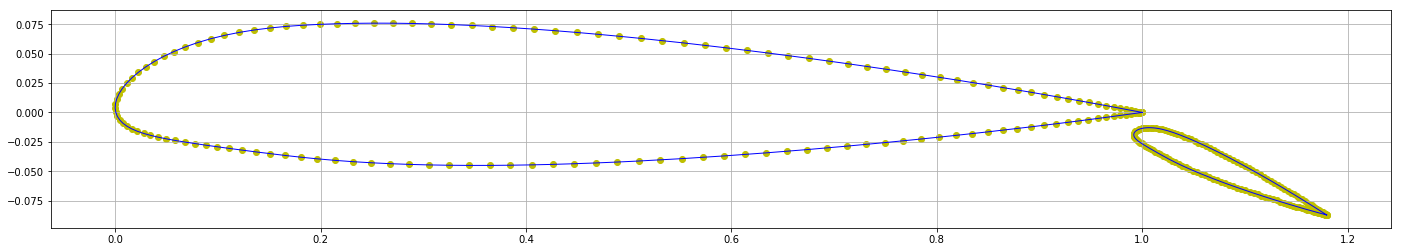

In [4]:
N,u_inf,alpha=len(xmain)-1,1,0
panels_m = define_panels(xmain, ymain, N)
panels_f = define_panels(x_fn, y_fn, N)

# plot discretized geometry
pyplot.figure(figsize=(24,4))
pyplot.plot(xmain, ymain, x_fn, y_fn,  color='b', linestyle='-', linewidth=1);
pyplot.grid(True)
panel_main, panel_flap = define_panels(xmain, ymain, N), define_panels(x_fn, y_fn, N)
pyplot.scatter([panel.xa for panel in panel_main], [panel.ya for panel in panel_main], color='y');
pyplot.scatter([panel.xa for panel in panel_flap], [panel.ya for panel in panel_flap], color='y');

In [5]:
panels=numpy.empty(N*2, dtype=object)
for i in range(N*2):
    if i<N:
        panels[i]=panels_m[i]
    elif i>=N:
        panels[i]=panels_f[i-N]

A_source=source_contribution_normal(panels)
B_vortex= vortex_contribution_normal(panels)
A = build_singularity_matrix(A_source, B_vortex)


In [6]:
alpha_1,alpha_2,alpha=-14,14,0
Lift,Lift_1=0,0
freestream = Freestream(u_inf,alpha_1)
b = build_freestream_rhs(panels,freestream)
strengths = numpy.linalg.solve(A, b)
for i , panel in enumerate(panels):
    panel.sigma = strengths[i]
gamma_m= strengths[-2]
gamma_f = strengths[-1]
compute_tangential_velocity(panels, freestream, gamma_m,gamma_f, A_source, B_vortex)
compute_pressure_coefficient(panels, freestream)
for panel in panels:
    Lift_1 -=panel.cp*numpy.sin(panel.beta)*panel.length

In [7]:
Lift_1

-0.41096499139773657

In [ ]:
error=1
lift_1=0
lift_2=0
while error>0.0001:
    alpha = 0.5*(alpha_1+alpha_2)
    freestream_1 = Freestream(u_inf,alpha)
    b_1 = build_freestream_rhs(panels,freestream_1)
    result_1 = numpy.linalg.solve(A, b_1)
    
    for i, panel in enumerate(panels):
        panel.sigma = result_1[i]
        
    gamma_1 = result_1[-2]
    gamma_2 = result_1[-1]
    compute_tangential_velocity(panels, freestream_1, gamma_1,gamma_2, A_source, B_vortex)
    compute_pressure_coefficient(panels, freestream_1)
    for panle in enumerate(panels):
        lift_1 -= panel.cp * panel.length * math.sin(panel.beta)
        
    freestream_2 = Freestream(u_inf,alpha_2)
    b_2 = build_freestream_rhs(panels,freestream_2)
    result_2 = numpy.linalg.solve(A, b_2)
    
    for i, panel in enumerate(panels):
        panel.sigma = result_2[i]
        
    gamma_11 = result_2[-2]
    gamma_22 = result_2[-1]
    compute_tangential_velocity(panels, freestream_2, gamma_11,gamma_22, A_source, B_vortex)
    compute_pressure_coefficient(panels, freestream_2)
    for panle in enumerate(panels):
        lift_2 -= panel.cp * panel.length * math.sin(panel.beta)
        
    if lift_1*lift_2 > 0.0:
        alpha_2=alpha
    else:
        alpha_1=alpha
        
    error = abs(lift_2)

In [ ]:
xmain, ymain=numpy.loadtxt("../AeroPython/lessons/resources/NACA23012_MainFoil.csv",dtype=float,delimiter=',',unpack=True)
xflap,yflap=numpy.loadtxt("../AeroPython/lessons/resources/NACA23012_FlapFoil.csv",dtype=float,delimiter=',',unpack=True)
panels_m = define_panels(xmain, ymain, N)
N = len(xmain)-1
u_inf = 1.
alpha = 0.
freestream = Freestream(u_inf,alpha)
point=[1.03, -0.054]
theta1=-5.
theta2=-2.
thata = 0.

In [ ]:
lift_1=0
lift_2=0
while error>0.0001:
    theta = 0.5*(theta1+theta2)
    b_1 = build_freestream_rhs(panels,freestream)
    x_fn, y_fn = rotation(point, theta1, xflap, yflap)
    panels=numpy.empty(N*2, dtype=object)
    for i in range(N*2):
        if i<N:
            panels[i]=panels_m[i]
        elif i>=N:
            panels[i]=panels_f[i-N]
    A_source=source_contribution_normal(panels)
    B_vortex= vortex_contribution_normal(panels)
    A = build_singularity_matrix(A_source, B_vortex)
    result_1 = numpy.linalg.solve(A, b_1)
    
    for i, panel in enumerate(panels):
        panel.sigma = result_1[i]
        
    gamma_1 = result_1[-2]
    gamma_2 = result_1[-1]
    compute_tangential_velocity(panels, freestream_1, gamma_1,gamma_2, A_source, B_vortex)
    compute_pressure_coefficient(panels, freestream_1)
    for panle in enumerate(panels):
        lift_1 -= panel.cp * panel.length * math.sin(panel.beta)
        
    x_fn, y_fn = rotation(point, theta, xflap, yflap)
    panels=numpy.empty(N*2, dtype=object)
    for i in range(N*2):
        if i<N:
            panels[i]=panels_m[i]
        elif i>=N:
            panels[i]=panels_f[i-N]
    A_source=source_contribution_normal(panels)
    B_vortex= vortex_contribution_normal(panels)
    A = build_singularity_matrix(A_source, B_vortex)
    result_1 = numpy.linalg.solve(A, b_1)
    
    for i, panel in enumerate(panels):
        panel.sigma = result_1[i]
        
    gamma_1 = result_1[-2]
    gamma_2 = result_1[-1]
    compute_tangential_velocity(panels, freestream_1, gamma_1,gamma_2, A_source, B_vortex)
    compute_pressure_coefficient(panels, freestream_1)
    for panle in enumerate(panels):
        lift_2 -= panel.cp * panel.length * math.sin(panel.beta)
        
    if lift_1*lift_2 > 0.0:
        theta2=theta
    else:
        theta1=alpha
        
    error = abs(lift_2)

In [ ]:
xmain, ymain=numpy.loadtxt("../AeroPython/lessons/resources/NACA23012_MainFoil.csv",dtype=float,delimiter=',',unpack=True)
xflap,yflap=numpy.loadtxt("../AeroPython/lessons/resources/NACA23012_FlapFoil.csv",dtype=float,delimiter=',',unpack=True)

point = [1.03, -0.054]
N = len(xmain)-1
u_inf = 1.
alpha = 4.

In [ ]:
theta_ar = numpy.array[0,5,10,15]
lift_theta = numpy.empty_like(theta_ar)
drag_theta = numpy.empty_like(theta_ar)

freestream = Freestream(u_inf,alpha)

In [ ]:
for i in range(len(theta_ar)):
    lift_theta[i] = 0
    lift, drag = 0, 0
    theta = theta_ar[i]
    x_fn, y_fn = rotation(point,theta,xflap,yflap)
    panels_main = define_panels(xmain,ymain,N)
    panels_flap = define_panels(xflap,yflap,N)
    for j in range(N*2):
        if j<N:
            panels[j]=panels_m[j]
        elif j>=N:
            panels[j]=panels_f[j-N]
    A_source=source_contribution_normal(panels)
    B_vortex= vortex_contribution_normal(panels)
    A = build_singularity_matrix(A_source, B_vortex)
    result_1 = numpy.linalg.solve(A, b_1)
    for j, panel in enumerate(panels):
        panels.sigma=result_1[j]
    gamma_1 = result_1[-2]
    gamma_2 = result_1[-1]
    compute_tangential_velocity(panels, freestream, gamma_1,gamma_2, A_source, B_vortex)
    compute_pressure_coefficient(panels, freestream)
    for panel in panels:
        lift -=panel.cp*numpy.sin(panel.beta)*panel.length
        drag +=panel.cp*numpy.cos(panel.beta)*panel.length
    lift_theta[i] = lift
    